In [1]:
!pip install transformers datasets evaluate -q
!pip install jiwer -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 17.7 MB/s eta 0:00:00


In [1]:
from huggingface_hub import notebook_login

notebook_login()

In [2]:
from datasets import load_dataset

#ds = load_dataset("lambdalabs/pokemon-blip-captions")
ds = load_dataset("polinaeterna/pokemon-blip-captions")

ds

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 833
    })
})

In [3]:
ds['train'][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1280x1280>,
 'text': 'a drawing of a green pokemon with red eyes'}

In [4]:
ds = ds["train"].train_test_split(test_size=0.1)
train_ds = ds["train"]
test_ds = ds["test"]

In [5]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 749
    })
    test: Dataset({
        features: ['image', 'text'],
        num_rows: 84
    })
})

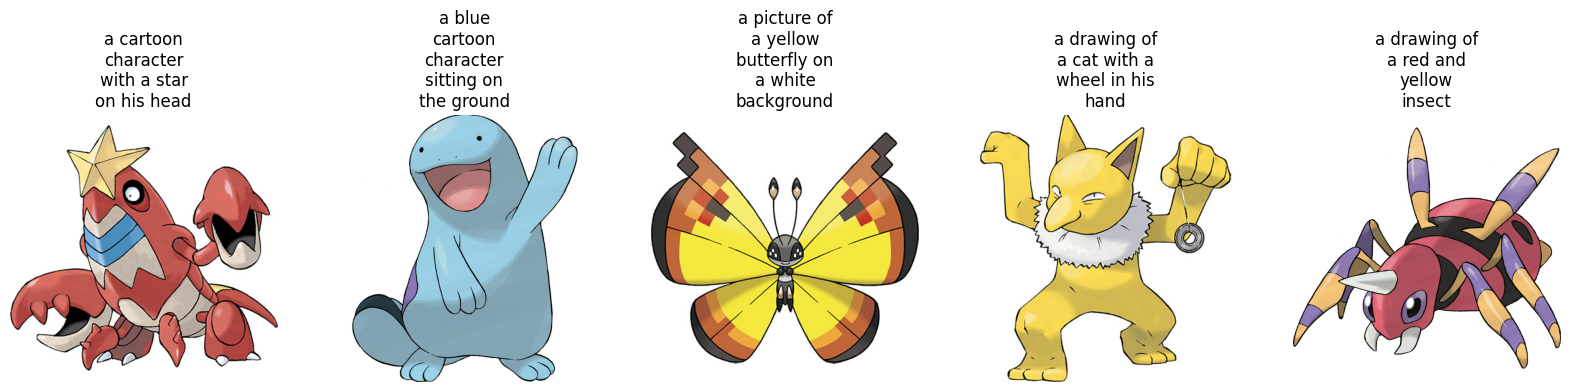

In [6]:
from textwrap import wrap
import matplotlib.pyplot as plt
import numpy as np


def plot_images(images, captions):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        caption = captions[i]
        caption = "\n".join(wrap(caption, 12))
        plt.title(caption)
        plt.imshow(images[i])
        plt.axis("off")


sample_images_to_visualize = [np.array(train_ds[i]["image"]) for i in range(5)]
sample_captions = [train_ds[i]["text"] for i in range(5)]
plot_images(sample_images_to_visualize, sample_captions)

In [3]:
#Preprocess the dataset
#Since the dataset has two modalities (image and text), the pre-processing pipeline will preprocess images and the captions.

#To do so, load the processor class associated with the model you are about to fine-tune.

from transformers import AutoProcessor

checkpoint = "microsoft/git-base"
processor = AutoProcessor.from_pretrained(checkpoint)

preprocessor_config.json:   0%|          | 0.00/503 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [8]:
#The processor will internally pre-process the image (which includes resizing, and pixel scaling) and tokenize the caption.


def transforms(example_batch):
    images = [x for x in example_batch["image"]]
    captions = [x for x in example_batch["text"]]
    inputs = processor(images=images, text=captions, padding="max_length")
    inputs.update({"labels": inputs["input_ids"]})
    return inputs


train_ds.set_transform(transforms)
test_ds.set_transform(transforms)

In [9]:
test_ds

Dataset({
    features: ['image', 'text'],
    num_rows: 84
})

In [10]:
#With the dataset ready, you can now set up the model for fine-tuning.

#Load a base model
#Load the “microsoft/git-base” into a AutoModelForCausalLM object.


from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(checkpoint)

In [11]:
#Evaluate
#Image captioning models are typically evaluated with the Rouge Score or Word Error Rate. For this guide, you will use the Word Error Rate (WER).

from evaluate import load
import torch

wer = load("wer")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predicted = logits.argmax(-1)
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
    wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
    return {"wer_score": wer_score}

In [12]:
#Train!
#start fine-tuning the model.
#!pip install accelerate -U
from transformers import TrainingArguments, Trainer

model_name = checkpoint.split("/")[1]
"""
training_args = TrainingArguments(
    output_dir=f"{model_name}-pokemon",
    learning_rate=5e-5,
    num_train_epochs=50,
    fp16=True,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=2,
    save_total_limit=3,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=50,
    logging_steps=50,
    remove_unused_columns=False,
    push_to_hub=True,
    label_names=["labels"],
    load_best_model_at_end=True,
)
"""
training_args = TrainingArguments(
    output_dir=f"{model_name}-pokemon",
    learning_rate=3e-5,
    num_train_epochs=20,
    fp16=True,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=2,
    save_total_limit=3,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=50,
    logging_steps=50,
    remove_unused_columns=False,
    push_to_hub=True,
    label_names=["labels"],
    load_best_model_at_end=True,
)



In [13]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [14]:
"""import torch, gc
gc.collect()
torch.cuda.empty_cache()
"""
trainer.train()

Step,Training Loss,Validation Loss,Wer Score
50,8.155000,6.431779,25.132484
100,5.338600,4.078196,18.648408
150,3.310900,2.430342,9.430573
200,2.047100,1.579711,8.959236


TrainOutput(global_step=240, training_loss=4.183178679148356, metrics={'train_runtime': 610.2281, 'train_samples_per_second': 24.548, 'train_steps_per_second': 0.393, 'total_flos': 7005885914603520.0, 'train_loss': 4.183178679148356, 'epoch': 20.0})

In [1]:
#!rm -rf /content/git-base-pokemon

In [15]:
#Once training is completed, share your model to the Hub with the push_to_hub() method so everyone can use your model:

trainer.push_to_hub()

events.out.tfevents.1713282971.8ad2e9937e6c.5415.0:   0%|          | 0.00/7.26k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/kr-manish/git-base-pokemon/commit/cc877293564ef4f56127eb9d5fd75d335d238624', commit_message='End of training', commit_description='', oid='cc877293564ef4f56127eb9d5fd75d335d238624', pr_url=None, pr_revision=None, pr_num=None)

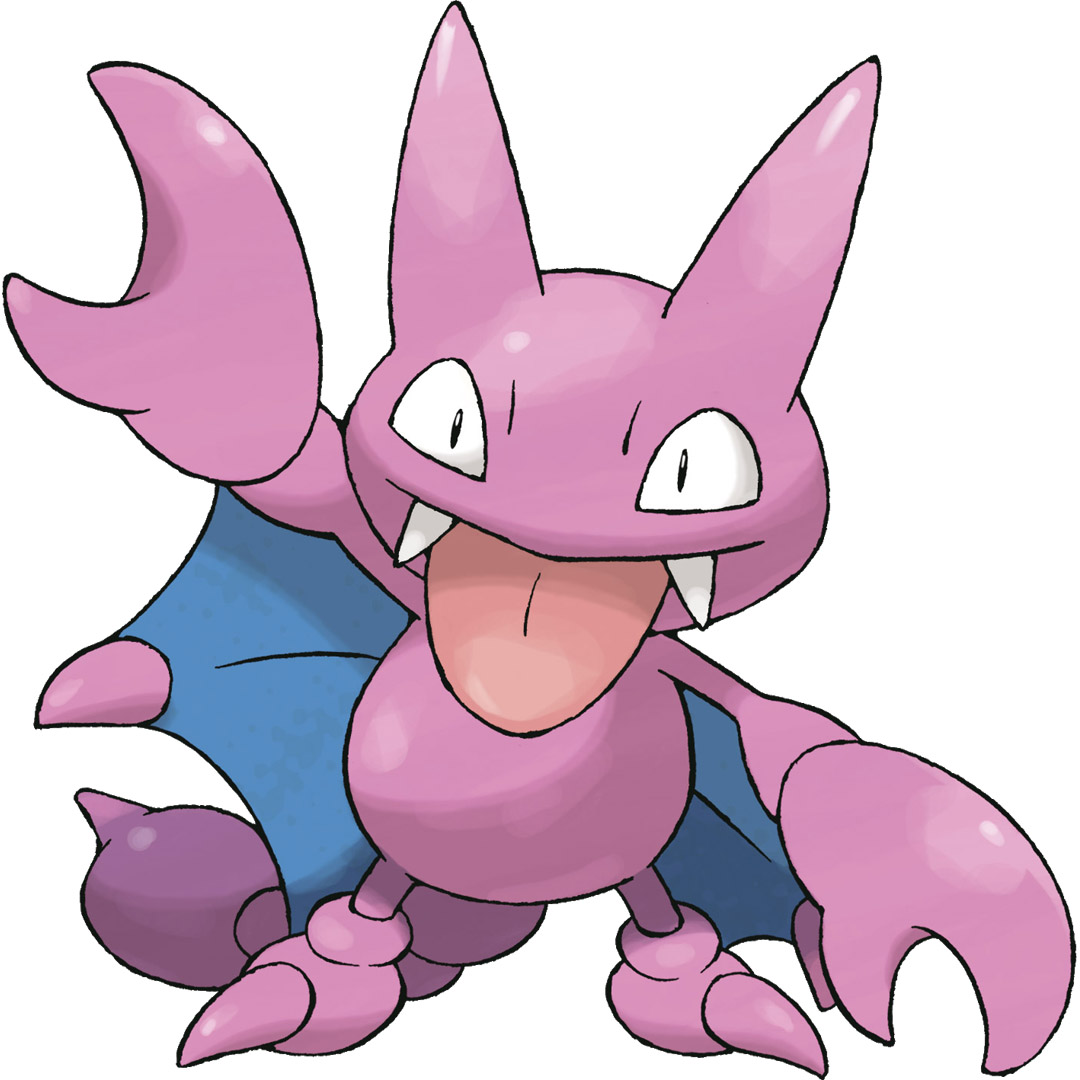

In [16]:
#Inference
#Take a sample image from test_ds to test the model.

from PIL import Image
import requests

url = "https://huggingface.co/datasets/sayakpaul/sample-datasets/resolve/main/pokemon.png"
image = Image.open(requests.get(url, stream=True).raw)
image

In [17]:
#Prepare image for the model.

device = "cuda" if torch.cuda.is_available() else "cpu"

inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

In [18]:
#Call generate and decode the predictions.

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

a pink and blue cartoon character with a blue shirt


In [4]:
from transformers import AutoProcessor, AutoModelForCausalLM
import torch
from PIL import Image
import requests

#Preprocess the dataset
#Since the dataset has two modalities (image and text), the pre-processing pipeline will preprocess images and the captions.

#To do so, load the processor class associated with the model you are about to fine-tune.

from transformers import AutoProcessor

checkpoint = "microsoft/git-base"
processor = AutoProcessor.from_pretrained(checkpoint)

device = "cuda" if torch.cuda.is_available() else "cpu"

model_name = "kr-manish/git-base-pokemon"  # Replace with your actual username and model name
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

url =  "https://huggingface.co/datasets/sayakpaul/sample-datasets/resolve/main/pokemon.png"  # Replace with the URL of your image
image = Image.open(requests.get(url, stream=True).raw)
inputs = processor(images=image, return_tensors="pt").to(device)

generated_ids = model.generate(pixel_values=inputs.pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)


a pink and purple pokemon character with big eyes
